# Position Weighted Heads Analysis

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import rcParams

rcParams['text.usetex'] = True

from pathlib import Path

from jupyter_utils.nanogpt_evaluation import (
    read_val_loss_from_log,
    parse_kaggle_log
)

In [2]:
def load_position_weights(ckpt_fp):
    from torch import load as t_load, device
    checkpoint = t_load(ckpt_fp, map_location=device("cpu"))["model"]
    return {
        k: checkpoint[k].numpy() for k in checkpoint if k.endswith("posweight")
    }

In [68]:
sksp_data_dir = Path("shakespeare-char", "v2")

sksp_results = {
    k: read_val_loss_from_log(Path(sksp_data_dir, k, "log.log")) for k in ["nano-h4", "posweight", "nano-h4-nopos"]
}

sksp_position_weights = load_position_weights(
    Path(sksp_data_dir, "posweight", "ckpt.pt")
)

In [8]:
owt_results = {}
for m in ["gpt2-default", "gpt2-posweight"]:
    expt_dir = Path("openwebtext3M", m)
    for log_file in expt_dir.glob("*.log"):
        if m not in owt_results:
            owt_results[m] = parse_kaggle_log(log_file)
        else:
            model_details, _val = owt_results[m]
            _, _vnew = parse_kaggle_log(log_file)
            _val = np.vstack((_val, _vnew))
            _val = _val[_val[:,0].argsort()]
            owt_results[m] = model_details, _val

owt_position_weights = load_position_weights(
    Path(expt_dir, "ckpt-12000.pt")
)

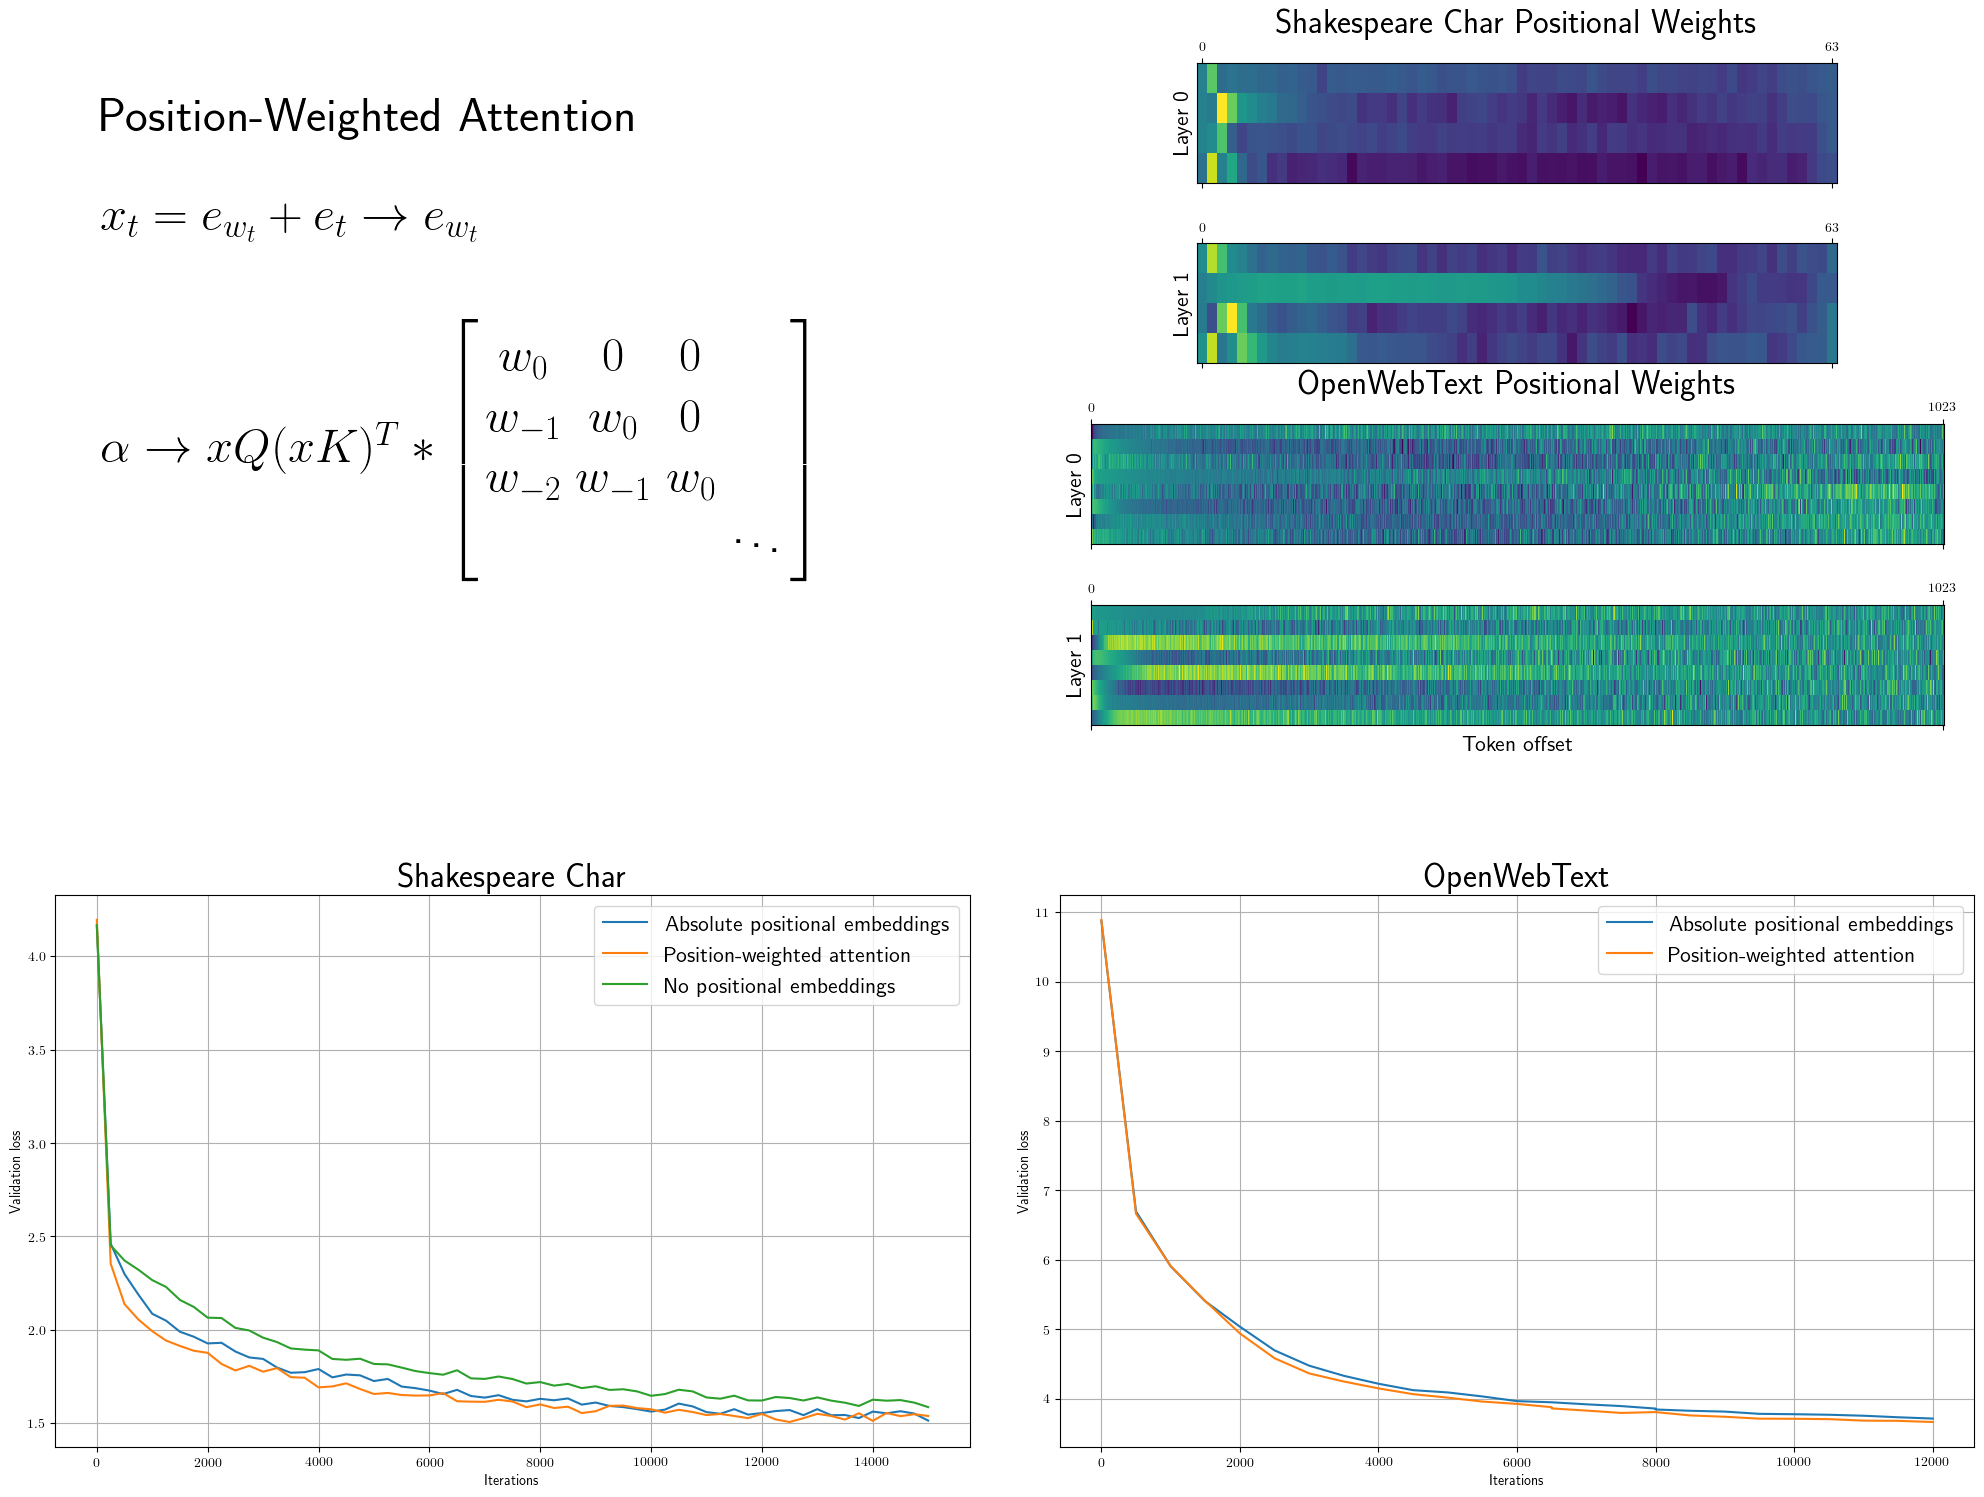

In [110]:
fig = plt.figure(figsize=(20, 15))

ax = fig.add_subplot(2, 2, 1)
ax.text(
    0.05,
    0.5,
    f"Position-Weighted Attention\n\n"
    r"$x_t = e_{w_t} + e_{t} \rightarrow e_{w_t}$"
    f"\n\n"
    r"$\alpha \rightarrow x Q (x K)^T \ast \left[\begin{array}{c c c c} w_0 & 0 & 0 & \\ w_{-1} & w_0 & 0 & \\ w_{-2} & w_{-1} & w_0 & \\ & & & \ddots \end{array}\right]$",
    ha="left",
    va="center",
    fontsize=35,
)
ax.axis("off")

ax = fig.add_subplot(2, 2, 3)
_lab = {
    "nano-h4": "Absolute positional embeddings",
    "nano-h4-nopos": "No positional embeddings",
    "posweight": "Position-weighted attention",
    "gpt2-default": "Absolute positional embeddings",
    "gpt2-posweight": "Position-weighted attention"
}
titfont = 24
for k, v in sksp_results.items():
    ax.plot(v[:, 0], v[:, 1], label=_lab.get(k))
ax.legend(loc="upper right", fontsize=16)
ax.grid()
ax.set_xlabel("Iterations")
ax.set_ylabel("Validation loss")
ax.set_title("Shakespeare Char", fontsize=titfont)

ax = fig.add_subplot(2, 2, 4)
for k, (_, v) in owt_results.items():
    ax.plot(v[:, 0], v[:, 1], label=_lab.get(k))
ax.legend(loc="upper right", fontsize=16)
ax.grid()
ax.set_xlabel("Iterations")
ax.set_ylabel("Validation loss")
ax.set_title("OpenWebText", fontsize=titfont)

_w = sksp_position_weights
_a = 3
for i in range(4):
    ax = fig.add_subplot(8, 2, 2 * (i + 1))
    if i == 2:
        ax.set_title("OpenWebText Positional Weights", fontsize=titfont)
        _w = owt_position_weights
        _a = 18
    _m = _w[f'transformer.h.{i}.attn.posweight']
    ax.matshow(
        _m, aspect=_a
    )
    ax.set_ylabel(f"Layer {i % 2}", fontsize=16)
    ax.set_xticks([0, _m.shape[1] - 1])
    ax.set_yticks([])
    if not i:
        ax.set_title("Shakespeare Char Positional Weights", fontsize=titfont)
ax.set_xlabel("Token offset", fontsize=16)

fig.tight_layout(pad=.8)
plt.show()